In [1]:
import os
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import yaml
import warnings
warnings.filterwarnings('ignore')

# Cấu hình plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
df = pd.read_csv('../data/images/annotation.csv')

print("📊 ORIGINAL DATASET INFORMATION")
print("=" * 60)
print(f"Total annotations: {len(df):,}")
print(f"Total unique images: {df['file_name'].nunique():,}")
print(f"Total classes: {df['category_id'].nunique()}")
print("\n📋 Dataset columns:")
print(df.columns.tolist())
print("\n🔍 Sample data (first 5 rows):")
df.head()

📊 ORIGINAL DATASET INFORMATION
Total annotations: 11,000
Total unique images: 4,500
Total classes: 7

📋 Dataset columns:
['area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'box_id', 'file_name', 'height', 'width', 'street_id', 'supercategory']

🔍 Sample data (first 5 rows):


,area,iscrowd,image_id,bbox,category_id,box_id,file_name,height,width,street_id,supercategory
0,342,0,3,"[880, 333, 19, 18]",2,0,3.png,626,1622,3,Cấm dừng và đỗ
1,63,0,5,"[768, 480, 9, 7]",2,2,5.png,626,1622,4,Cấm dừng và đỗ
2,56,0,16,"[733, 352, 7, 8]",2,4,16.png,626,1622,3,Cấm dừng và đỗ
3,5400,0,17,"[1024, 160, 75, 72]",2,5,17.png,626,1622,8,Cấm dừng và đỗ
4,1927,0,18,"[1138, 295, 47, 41]",2,6,18.png,626,1622,3,Cấm dừng và đỗ


In [3]:
print("\n📈 STATISTICS BY CLASS")
print("=" * 60)
class_stats = df.groupby(['category_id', 'supercategory']).agg({
    'box_id': 'count',
    'area': ['mean', 'std', 'min', 'max']
}).round(2)
class_stats.columns = ['Count', 'Mean_Area', 'Std_Area', 'Min_Area', 'Max_Area']
print(class_stats)


📈 STATISTICS BY CLASS
                             Count  Mean_Area  Std_Area  Min_Area  Max_Area
category_id supercategory                                                  
1           Cấm ngược chiều   1416     538.40   1428.91         4     15006
2           Cấm dừng và đỗ    2221    1368.00   3135.65         9     54526
3           Cấm rẽ             556    1705.58   3451.42        24     24402
4           Giới hạn tốc độ    949     828.65   1552.66         9     22363
5           Cấm còn lại       1787    1069.71   2547.62         9     45024
6           Nguy hiểm         3049    1164.60   2960.21         9     47736
7           Hiệu lệnh         1022     696.79   1928.02         6     27300


In [4]:
print("\n📐 IMAGE SIZE STATISTICS")
print("=" * 60)
img_sizes = df[['file_name', 'width', 'height']].drop_duplicates()
print(f"Unique image sizes: {img_sizes[['width', 'height']].drop_duplicates().values.tolist()}")
print(f"Width: {img_sizes['width'].unique()}")
print(f"Height: {img_sizes['height'].unique()}")


📐 IMAGE SIZE STATISTICS
Unique image sizes: [[1622, 626]]
Width: [1622]
Height: [626]


In [5]:
# Get unique classes from dataset
unique_classes = df[['category_id', 'supercategory']].drop_duplicates().sort_values('category_id')

print("📝 ORIGINAL CLASS MAPPING FROM ZALO")
print("=" * 60)
print(unique_classes.to_string(index=False))

# Mapping from original category_id to YOLO class ID (0-6) and English names
# Format: category_id -> (yolo_class_id, english_name)
category_to_yolo = {
    6: (0, 'warning'),
    2: (1, 'no parking/waiting'),
    5: (2, 'other prohibition signs'),
    1: (3, 'no entry'),
    7: (4, 'mandatory'),
    4: (5, 'max speed'),
    3: (6, 'no turning')
}

# Create YOLO class names dictionary (0-6)
class_names = {yolo_id: eng_name for _, (yolo_id, eng_name) in category_to_yolo.items()}
num_classes = len(class_names)

# Add yolo_class_id to dataframe
df['yolo_class_id'] = df['category_id'].map(lambda x: category_to_yolo.get(x, (x, 'unknown'))[0])
df['class_name_en'] = df['category_id'].map(lambda x: category_to_yolo.get(x, (x, 'unknown'))[1])

print(f"\n📝 YOLO CLASS MAPPING (for training)")
print("=" * 60)
for yolo_id in sorted(class_names.keys()):
    print(f"  {yolo_id}: {class_names[yolo_id]}")

print(f"\n✅ Total classes: {num_classes}")

📝 ORIGINAL CLASS MAPPING FROM ZALO
 category_id   supercategory
           1 Cấm ngược chiều
           2  Cấm dừng và đỗ
           3          Cấm rẽ
           4 Giới hạn tốc độ
           5     Cấm còn lại
           6       Nguy hiểm
           7       Hiệu lệnh

📝 YOLO CLASS MAPPING (for training)
  0: warning
  1: no parking/waiting
  2: other prohibition signs
  3: no entry
  4: mandatory
  5: max speed
  6: no turning

✅ Total classes: 7


In [6]:
# Get list of unique images
image_files = df['file_name'].unique()
print(f"📂 Total unique images: {len(image_files)}")

# Split: 70% train, 20% val, 10% test
train_imgs, temp_imgs = train_test_split(
    image_files, test_size=0.3, random_state=42, shuffle=True
)
val_imgs, test_imgs = train_test_split(
    temp_imgs, test_size=0.33, random_state=42, shuffle=True
)

print(f"\n📊 DATASET SPLIT")
print("=" * 60)
print(f"🟦 Train: {len(train_imgs):,} images ({len(train_imgs)/len(image_files)*100:.1f}%)")
print(f"🟨 Val:   {len(val_imgs):,} images ({len(val_imgs)/len(image_files)*100:.1f}%)")
print(f"🟥 Test:  {len(test_imgs):,} images ({len(test_imgs)/len(image_files)*100:.1f}%)")

# Create mapping dictionary
split_dict = {}
for img in train_imgs:
    split_dict[img] = 'train'
for img in val_imgs:
    split_dict[img] = 'val'
for img in test_imgs:
    split_dict[img] = 'test'

df['split'] = df['file_name'].map(split_dict)

📂 Total unique images: 4500

📊 DATASET SPLIT
🟦 Train: 3,150 images (70.0%)
🟨 Val:   904 images (20.1%)
🟥 Test:  446 images (9.9%)


In [7]:
def convert_bbox_to_yolo(bbox_str, img_width, img_height):
    """
    Convert COCO bbox [x_min, y_min, width, height] 
    to YOLO format [x_center, y_center, width, height] (normalized)
    """
    bbox = json.loads(bbox_str)
    x_min, y_min, bbox_width, bbox_height = bbox
    
    # Calculate center
    x_center = (x_min + bbox_width / 2) / img_width
    y_center = (y_min + bbox_height / 2) / img_height
    
    # Normalize width and height
    norm_width = bbox_width / img_width
    norm_height = bbox_height / img_height
    
    return x_center, y_center, norm_width, norm_height

# Tạo thư mục output
for split in ['train', 'val', 'test']:
    Path(f'../data/images/{split}').mkdir(parents=True, exist_ok=True)
    Path(f'../data/labels/{split}').mkdir(parents=True, exist_ok=True)

print("🔄 Converting annotations to YOLO format...")
print("=" * 60)

conversion_stats = {'train': 0, 'val': 0, 'test': 0}

for split in ['train', 'val', 'test']:
    split_df = df[df['split'] == split]
    
    for image_file, group in split_df.groupby('file_name'):
        img_width = group.iloc[0]['width']
        img_height = group.iloc[0]['height']
        
        # Tạo file .txt label
        label_file = Path(f'../data/labels/{split}') / f"{Path(image_file).stem}.txt"
        
        with open(label_file, 'w') as f:
            for _, row in group.iterrows():
                # Sử dụng category_id gốc từ dataset
                class_id = row['category_id']
                x_c, y_c, w, h = convert_bbox_to_yolo(
                    row['bbox'], img_width, img_height
                )
                f.write(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")
        
        conversion_stats[split] += 1

print("✅ Conversion completed!")
for split, count in conversion_stats.items():
    print(f"   {split.capitalize()}: {count} label files created")

# Verify một file mẫu
sample_label = Path('../data/labels/train').glob('*.txt').__next__()
print(f"\n📝 Sample label file ({sample_label.name}):")
print(sample_label.read_text()[:200] + "...")

🔄 Converting annotations to YOLO format...


✅ Conversion completed!
   Train: 3150 label files created
   Val: 904 label files created
   Test: 446 label files created

📝 Sample label file (10002.txt):
6 0.435265 0.555911 0.008631 0.022364
6 0.435573 0.555911 0.006782 0.019169
...


In [8]:
config = {
    'path': './data',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': num_classes,
    'names': class_names  # YOLO format: {0: 'warning', 1: 'no parking/waiting', ...}
}

config_path = Path('../configs/zalo.yaml')
config_path.parent.mkdir(parents=True, exist_ok=True)

with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False, sort_keys=False)

print("✅ Config file created: configs/zalo.yaml")
print("\n📄 Config content:")
print(yaml.dump(config, default_flow_style=False))


✅ Config file created: configs/zalo.yaml

📄 Config content:
names:
  0: warning
  1: no parking/waiting
  2: other prohibition signs
  3: no entry
  4: mandatory
  5: max speed
  6: no turning
nc: 7
path: ./data
test: images/test
train: images/train
val: images/val



In [9]:
split_class_stats = df.groupby(['split', 'supercategory']).size().unstack(fill_value=0)


print("📊 CLASS DISTRIBUTION BY SPLIT")
print("=" * 80)
print(split_class_stats)
print("\n📈 Total per split:")
print(split_class_stats.sum(axis=1))
print("\n📈 Total per class:")
print(split_class_stats.sum(axis=0))

📊 CLASS DISTRIBUTION BY SPLIT
supercategory  Cấm còn lại  Cấm dừng và đỗ  Cấm ngược chiều  Cấm rẽ  \
split                                                                 
test                   166             225              126      57   
train                 1276            1523             1015     389   
val                    345             473              275     110   

supercategory  Giới hạn tốc độ  Hiệu lệnh  Nguy hiểm  
split                                                 
test                        89        106        285  
train                      627        708       2194  
val                        233        208        570  

📈 Total per split:
split
test     1054
train    7732
val      2214
dtype: int64

📈 Total per class:
supercategory
Cấm còn lại        1787
Cấm dừng và đỗ     2221
Cấm ngược chiều    1416
Cấm rẽ              556
Giới hạn tốc độ     949
Hiệu lệnh          1022
Nguy hiểm          3049
dtype: int64


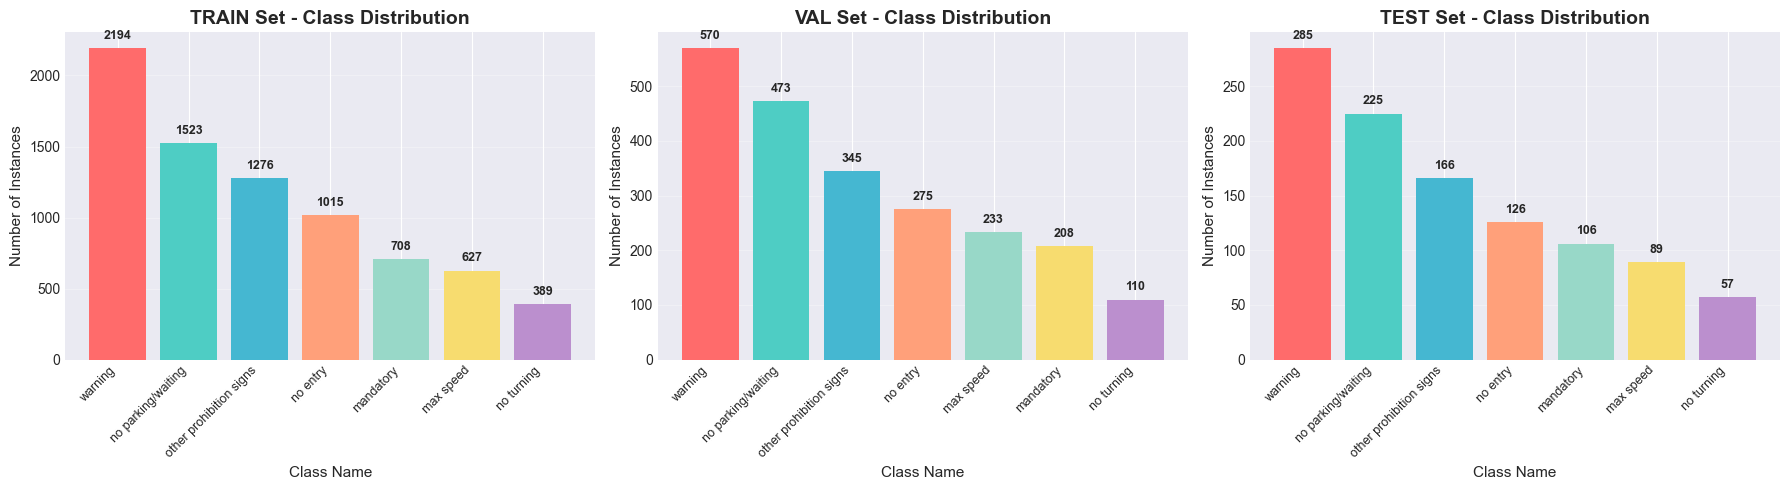

✅ Saved plot at: ..\notebook\plots\class_distribution.png


In [11]:
from pathlib import Path
import matplotlib.pyplot as plt

# Tạo thư mục plots nếu chưa có
output_dir = Path('../notebook/plots')
output_dir.mkdir(parents=True, exist_ok=True)

# Vẽ và lưu hình
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']

for idx, split in enumerate(['train', 'val', 'test']):
    split_data = df[df['split'] == split]['class_name_en'].value_counts()
    
    axes[idx].bar(range(len(split_data)), split_data.values, color=colors[:len(split_data)])
    axes[idx].set_xticks(range(len(split_data)))
    axes[idx].set_xticklabels(split_data.index, rotation=45, ha='right', fontsize=9)
    axes[idx].set_title(f'{split.upper()} Set - Class Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Class Name', fontsize=11)
    axes[idx].set_ylabel('Number of Instances', fontsize=11)
    axes[idx].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(split_data.values):
        axes[idx].text(i, v + max(split_data.values)*0.02, str(v), 
                      ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()

# ✅ Lưu file bằng Path (chắc chắn hợp lệ)
save_path = output_dir / 'class_distribution.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved plot at: {save_path}")


In [12]:
# Class imbalance analysis
class_counts = df['class_name_en'].value_counts()
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\n⚖️ CLASS IMBALANCE ANALYSIS")
print("=" * 60)
print(f"Most common class: {class_counts.index[0]} ({max_count:,} instances)")
print(f"Least common class: {class_counts.index[-1]} ({min_count:,} instances)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 5:
    print("⚠️  High class imbalance detected!")
    print("💡 Recommendation: Use weighted loss or data augmentation")
elif imbalance_ratio > 3:
    print("⚠️  Moderate class imbalance")
    print("💡 Recommendation: Monitor per-class performance")
else:
    print("✅ Classes are relatively balanced")


⚖️ CLASS IMBALANCE ANALYSIS
Most common class: warning (3,049 instances)
Least common class: no turning (556 instances)
Imbalance ratio: 5.48x
⚠️  High class imbalance detected!
💡 Recommendation: Use weighted loss or data augmentation
